In [1]:
import pypesto
import pypesto.petab
import pypesto.optimize as optimize
import pypesto.sample as sample
import pypesto.visualize as visualize

import petab
import numpy as np
from scipy.special import gammaln
from scipy.special import gamma
import pickle
from scipy import integrate
from copy import deepcopy
from time import process_time
import matplotlib.pyplot as plt

datatype = "original"

# import to petab
if datatype == "original":
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_original.yaml")
elif datatype == "switch":
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_switch.yaml")
else:
    petab_problem = petab.Problem.from_yaml(
    "corrupted_data/SS_conversion_reaction_loss.yaml")

In [2]:
def analytical_b(t, a0, b0, k1, k2):
    return (k2 - k2 * np.exp(-(k2 + k1) * t)) / (k2 + k1)

def simulate_model(x, tvec):
    # assign parameters
    k1, k2, _ = x
    # define initial conditions
    a0 = 1
    b0 = 0
    # simulate model
    simulation = [analytical_b(t, a0, b0, k1, k2)
                   for t in tvec]
    return simulation

In [3]:
def log_prior(offset):
    """ Log prior function -- exponential prior."""
    return np.log(lamda) - lamda * offset


def negative_log_posterior(offset, data, simulation, scale):
    """ Negative log posterior function."""

    N = len(data)
    
    # evaluate standard log likelihood
    res = data - simulation
    b_vector = np.sort(res)
    
    sum_res = np.sum(abs(offset-b_vector)) / scale

    l_llh = - sum_res+N*(- np.log(2) -np.log(scale))

    # evaluate log normal-gamma prior
    l_prior = log_prior(offset)

    # return log posterior
    return (l_llh + l_prior)

def evaluate_posterior_standard(offset, data, simulation, scale):
    # evaluate log posterior
    _P = negative_log_posterior(offset, data, simulation, scale)
    
    # transform to posterior (not log)
    return np.exp(_P)

def log_numerical_integration_offset(data, simulation, scale):
    marginal_posterior, _ = integrate.quad(evaluate_posterior_standard, 
                                           -np.inf, np.inf,
                                           args=(data, simulation, scale))
    return np.log(marginal_posterior)

In [4]:
def log_marginalised_likelihood(data, simulation, scale):
    
    N = len(data)
    
    # evaluate standard log likelihood
    res = data - simulation
    b_vector = np.sort(res)
    
    bounds = np.append(np.append(-np.inf, b_vector), np.inf)
    r = np.argmax(bounds >= 0)-1
    
    marginal_posterior = 0
    for n in range(len(bounds)-1):
        l_value = np.sum(b_vector[:n]) - np.sum(b_vector[n:])
        tmp = l_value/scale
        if n < r:
            aux1 = scale/(N-2*r-scale*lamda)
            aux2 = (np.exp(tmp+bounds[r]*((N-2*r)/scale-lamda))-np.exp(tmp))

        elif n == len(bounds)-2:
            aux1 = scale/(N+scale*lamda)
            aux2 = np.exp(tmp+bounds[n]*(-N/scale-lamda))

        else:
            aux = (N-2*n)/scale-lamda
            aux1 = scale/(N-2*n-scale*lamda)
            aux2 = np.exp(tmp+bounds[n+1]*aux)-np.exp(tmp+bounds[n]*aux)
        
        marginal_posterior += aux1*aux2
        
    log_marginal_posterior = np.log(marginal_posterior)
    log_marginal_posterior += N*(- np.log(2) -np.log(scale))+np.log(lamda) 
    
    return log_marginal_posterior

In [5]:
x0 = np.array([-1.2741, -0.6160, 0.3684])
lamda = 0.01
scale = x0[-1]

# experimental data
data = np.asarray(petab_problem.measurement_df.measurement)
# time vector
tvec = np.asarray(petab_problem.measurement_df.time)

# simulate model
_simulation = simulate_model(np.exp(x0), tvec)
simulation = np.asarray(_simulation)

print(log_numerical_integration_offset(data, simulation, scale))
print(log_marginalised_likelihood(data, simulation, scale))

-4.163947227276439
-4.1639471678254525


In [6]:
x0 = np.array([-1.2741, -0.6160, 0.3684])
lamda = 0.01
scale = x0[-1]

# experimental data
data = np.asarray(petab_problem.measurement_df.measurement)
# time vector
tvec = np.asarray(petab_problem.measurement_df.time)

# parameter values
k1_values = np.arange(-10, 10, 0.1)

numerical = []
analytical = []

numerical_t = []
analytical_t = []

calculate = False
save_results = False

if calculate:
    for k1 in k1_values:
        
        # update parameter vector
        x0[0] = k1

        # simulate model
        _simulation = simulate_model(np.exp(x0), tvec)
        simulation = np.asarray(_simulation)

        # evaluate numerical integration
        t_start = process_time()
        _numerical = np.exp(log_numerical_integration_offset(data, simulation, scale))
        t_elapsed = process_time() - t_start
        
        numerical.append(_numerical)
        numerical_t.append(t_elapsed)

        # evaluate analytical integration
        t_start = process_time()
        _analytical = np.exp(log_marginalised_likelihood(data, simulation, scale))
        t_elapsed = process_time() - t_start
        
        analytical.append(_analytical)
        analytical_t.append(t_elapsed)

    # convert to numpy arrays
    numerical = np.asarray(numerical)
    analytical = np.asarray(analytical)
    numerical_t = np.asarray(numerical_t)
    analytical_t = np.asarray(analytical_t)

if not calculate:
    save_results = False

if save_results:
    result = {}
    result['analytical'] = analytical
    result['analytical_t'] = analytical_t
    result['numerical'] = numerical
    result['numerical_t'] = numerical_t

    with open('result_testIntegral_Laplace-onlyOffset.pickle', 
              'wb') as result_file:
        pickle.dump([result, lamda], result_file)
        result_file.close()

if calculate:
    load_results = False
else:
    load_results = True
        
if load_results:
    filename = './result_testIntegral_Laplace-onlyOffset.pickle'
    result, lamda = pickle.load(open(filename, 'rb'))
    
    analytical = result['analytical']
    analytical_t = result['analytical_t']
    numerical = result['numerical']
    numerical_t = result['numerical_t']

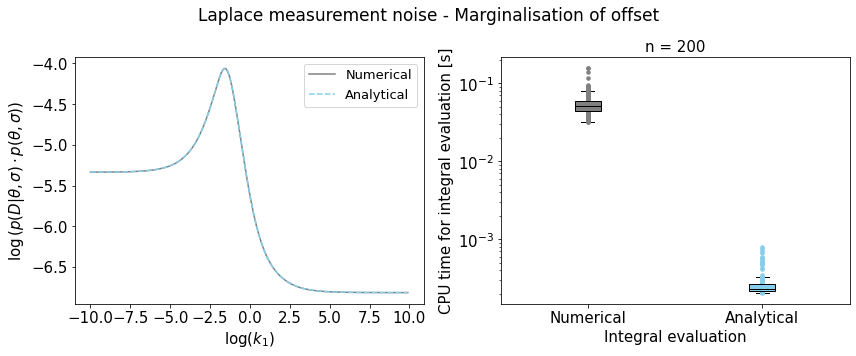

In [7]:
colors = ['gray', 'skyblue']
labels=['Numerical', 'Analytical']

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)

plt.plot(k1_values, np.log(numerical), '-',label = labels[0], color=colors[0])
plt.plot(k1_values, np.log(analytical), '--', label = labels[1], color=colors[1])
plt.ylabel(r'$\log \left(p(D|\theta,\sigma) \cdot p(\theta,\sigma) \right)$', fontsize=15)
plt.xlabel(r'$\log(k_1)$', fontsize=15)
plt.legend(loc='best', fontsize=13)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.subplot(1,2,2)
bplot = plt.boxplot([numerical_t, analytical_t], 
                    patch_artist=True, labels=labels,
                    medianprops=dict(color='k'), showfliers=False)
plt.plot(np.ones((len(numerical_t))), numerical_t, '.', color=colors[0], ms=7)
plt.plot(2*np.ones((len(analytical_t))), analytical_t, '.', color=colors[1], ms=7)
# plt.ylim([0,40])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.yscale('log')
plt.ylabel('CPU time for integral evaluation [s]',fontsize=15)
plt.xlabel('Integral evaluation',fontsize=15)

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    
plt.title('n = '+str(len(analytical_t)),fontsize=15)
plt.suptitle('Laplace measurement noise - Marginalisation of offset',fontsize=17)
plt.tight_layout()
# plt.savefig('./testIntegral-Laplace-onlyOffset.pdf', bbox_inches = 'tight')
plt.show()